In [ ]:
#importing necessary libraries for data expolaration
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates
from datetime import datetime
from sklearn import linear_model
from numpy import polyfit
from scipy.optimize import curve_fit
import seaborn as sns

## Initial data preprocessign and exploration

In [ ]:
#Preprocessing data
df = pd.read_excel('Problem_C_Data_Wordle.xlsx') #load in excel file
df = df.drop(df.columns[[0]], axis=1)  # drop the first NaN containing columns
df.columns = df.iloc[0] #rename dataframe columns to the ones in the excel
df.drop(index=0) #drop the extra first row

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
1,2022-12-31 00:00:00,560,manly,20380,1899,0,2,17,37,29,12,2
2,2022-12-30 00:00:00,559,molar,21204,1973,0,4,21,38,26,9,1
3,2022-12-29 00:00:00,558,havoc,20001,1919,0,2,16,38,30,12,2
4,2022-12-28 00:00:00,557,impel,20160,1937,0,3,21,40,25,9,1
5,2022-12-27 00:00:00,556,condo,20879,2012,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2022-01-11 00:00:00,206,drink,153880,3017,1,9,35,34,16,5,1
356,2022-01-10 00:00:00,205,query,107134,2242,1,4,16,30,30,17,2
357,2022-01-09 00:00:00,204,gorge,91477,1913,1,3,13,27,30,22,4
358,2022-01-08 00:00:00,203,crank,101503,1763,1,5,23,31,24,14,2


In [ ]:
df.describe()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
count,360,360,360,360,360,360,360,360,360,360,360,360
unique,360,360,360,358,345,7,23,37,33,32,31,22
top,Date,Contest number,Word,36223,10343,0,2,16,35,24,9,1
freq,1,1,1,2,2,221,56,19,38,32,30,146


In [ ]:
column_names = list(df.columns.values)
column_names

['Date',
 'Contest number',
 'Word',
 'Number of  reported results',
 'Number in hard mode',
 '1 try',
 '2 tries',
 '3 tries',
 '4 tries',
 '5 tries',
 '6 tries',
 '7 or more tries (X)']

## Daily reports

In [ ]:
indx = df["Contest number"].to_numpy()[1:]
number_of_results = df["Number of  reported results"].to_numpy()[1:]
number_of_hard_results = df["Number in hard mode"].to_numpy()[1:]

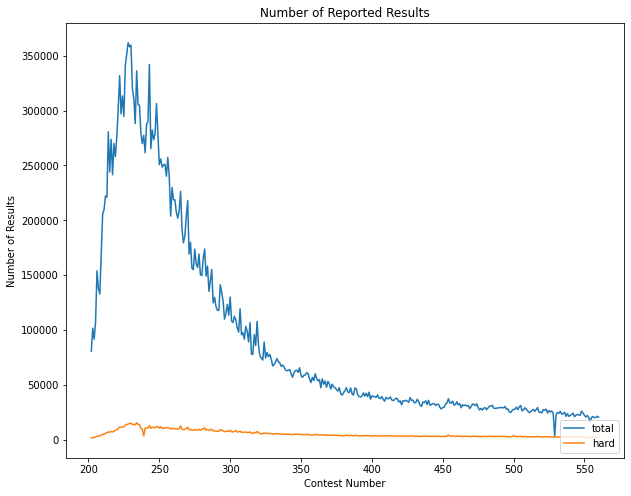

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(indx, number_of_results)
plt.plot(indx, number_of_hard_results)
plt.title('Number of Reported Results')
plt.xlabel('Contest Number')
plt.ylabel('Number of Results')
plt.legend(["total", "hard"], loc ="lower right")
plt.savefig('Number of Reported Results.png', bbox_inches='tight')
plt.show()

<ipython-input-7-829ef0f25f3b>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot()


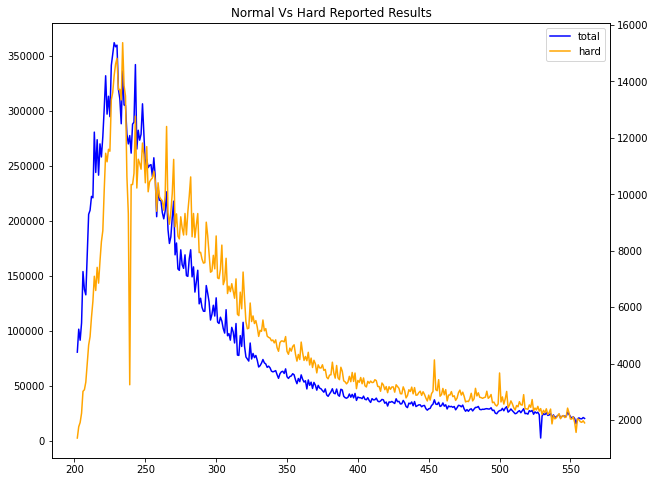

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Normal Vs Hard Reported Results')
plt.rcParams["figure.autolayout"] = True
ax1 = plt.subplot()
l1, = ax1.plot(indx, number_of_results, color='blue')
ax2 = ax1.twinx()
l2, = ax2.plot(indx, number_of_hard_results, color='orange')
plt.legend([l1, l2], ["total", "hard"])
plt.savefig('Normal Vs Hard Reported Results.png')
plt.show()

In [ ]:
#outlier hard words (we see that the hard modes were reported with the same distribution as normal mode except for the one around 240)
df.loc[322, :] #robin is the outlier with a drop from a previous 9000 hard plays the day before to around 3000

0
Date                           2022-02-13 00:00:00
Contest number                                 239
Word                                         robin
Number of  reported results                 277471
Number in hard mode                           3249
1 try                                            1
2 tries                                          6
3 tries                                         29
4 tries                                         34
5 tries                                         21
6 tries                                          8
7 or more tries (X)                              1
Name: 322, dtype: object

### Regression on number of players

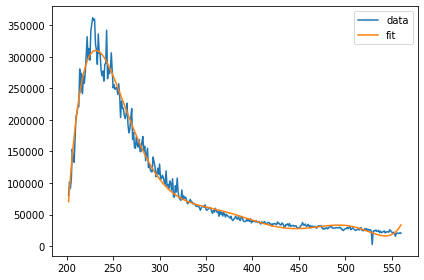

In [ ]:
#Fitting using polynomial regression
poly = np.polyfit(list(indx), list(number_of_results), deg=7)

fig, ax = plt.subplots()

ax.plot(indx, number_of_results, label='data')
ax.plot(indx, np.polyval(poly, indx), label='fit')
ax.legend()

In [ ]:
np.polyval(poly, 590) # very shit

292000.69922822714

### Fitting with gaussian function

381.0 468864396126.0


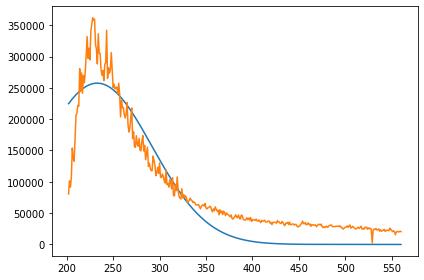

In [ ]:
#Gaussian function
def gauss_function(x, a, x0, sigma):
  return a*np.exp(-(x-x0)**2/(2*sigma**2))

x = np.asarray(indx).astype(int)
y = np.asarray(number_of_results).astype(int)

#estimate mean and standard deviation
mean = np.mean(x)
sigma = sum(y * (x - mean)**2)
print(mean, sigma)
#do the fit!
popt, pcov = curve_fit(gauss_function, x, y, p0 = [2, 240, 20])
#plot the fit results
plt.plot(x, gauss_function(x, *popt))
#confront with the given data
plt.plot(x,y)

## Difficulty distribution Prediction

In [ ]:
probabilities = df[['1 try','2 tries','3 tries','4 tries','5 tries','6 tries','7 or more tries (X)']].to_numpy()[1:]

In [ ]:
# prob_dist is an (359, 7) np array of the probabilities in percent form
prob_dist = probabilities/100
# occ is an (359, 7) np array of the occurences of the number of tries for each word
occ =  (probabilities/100).T * number_of_results
occ = np.around(occ.astype(float)).T
#word is a np array of all of the word
words = df["Word"].to_numpy()[1:]

In [ ]:
#libraries
#for NN
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import LSTM, Dense
#for word embedding
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

### One-hot Encoding the data

In [ ]:
#one hot encoding
def onehot(input_data): 

  # Define the vocabulary
  vocabulary = sorted(set("".join(input_data)))

  # Create a dictionary mapping characters to indices
  char_to_index = dict((c, i) for i, c in enumerate(vocabulary))

  # Define the maximum input length
  max_length = max(len(word) for word in input_data)

  # Encode each word using one-hot encoding
  encoded_data = np.zeros((len(input_data), max_length, len(vocabulary)), dtype=np.float32)
  for i, word in enumerate(input_data):
      for j, char in enumerate(word):
          encoded_data[i, j, char_to_index[char]] = 1.0

  return encoded_data

In [ ]:
#Run onehot function here if we end up using it

### Creating word embeddings and Visualizations

In [64]:
#takes in array of words and dimension of embedding, returns embeddings array and actual model
def create_word_embeddings(words, dim = 100, plot = False, highlight_last = False):
  # define the dataset
  data = [[item] for item in words]
  # train the model
  embed_model = Word2Vec(data, size=dim, window=5, min_count=1, workers=4)

  # Get the vocabulary and the corresponding embeddings
  vocab = list(embed_model.wv.vocab)
  embeddings = embed_model.wv[vocab]

  if plot == True:
    # Use t-SNE to reduce the dimensionality of the embeddings to 2D
    tsne = TSNE(n_components=2, perplexity = 40, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

  # Plot the embeddings
  plt.figure(figsize=(12, 12))
  for i, word in enumerate(words):
      x, y = embeddings_2d[i, :]
      if i != np.size(words)-1:
        plt.scatter(x, y, marker='o', color='blue') 
      else:
        if highlight_last:
          plt.scatter(x, y, marker='o', color='orange') 
        else:
          plt.scatter(x, y, marker='o', color='blue') 

      plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  plt.show()

  return embeddings, embed_model, embeddings_2d

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


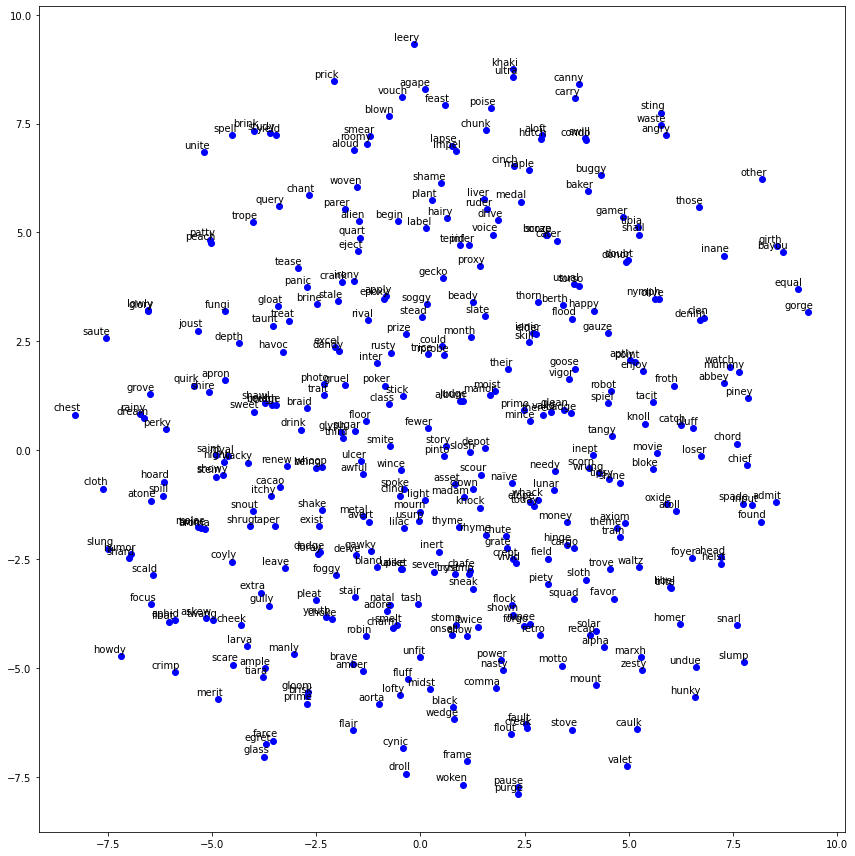

In [65]:
# Get the vocabulary and the corresponding embeddings
embeddings, _, embed_2d = create_word_embeddings(words, 30, True)

### Neural Network Approach

Epoch 1/45
41/41 [==============================] - 1s 6ms/step - loss: 1.9443 - accuracy: 0.2941 - val_loss: 1.9363 - val_accuracy: 0.3333
Epoch 2/45
41/41 [==============================] - 0s 3ms/step - loss: 1.9385 - accuracy: 0.4427 - val_loss: 1.9300 - val_accuracy: 0.2500
Epoch 3/45
41/41 [==============================] - 0s 3ms/step - loss: 1.9309 - accuracy: 0.3437 - val_loss: 1.9206 - val_accuracy: 0.1944
Epoch 4/45
41/41 [==============================] - 0s 3ms/step - loss: 1.9214 - accuracy: 0.2693 - val_loss: 1.9106 - val_accuracy: 0.1389
Epoch 5/45
41/41 [==============================] - 0s 3ms/step - loss: 1.9114 - accuracy: 0.2415 - val_loss: 1.9001 - val_accuracy: 0.1111
Epoch 6/45
41/41 [==============================] - 0s 2ms/step - loss: 1.9008 - accuracy: 0.1827 - val_loss: 1.8888 - val_accuracy: 0.0556
Epoch 7/45
41/41 [==============================] - 0s 2ms/step - loss: 1.8895 - accuracy: 0.1610 - val_loss: 1.8770 - val_accuracy: 0.0556
Epoch 8/45
41/41 [==

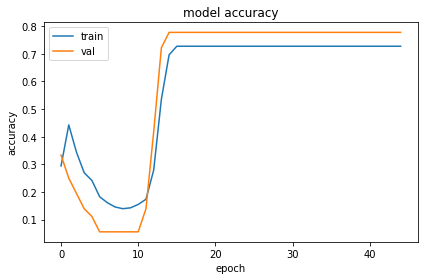

In [59]:

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(embeddings.shape[1],)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with appropriate loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=None, ema_momentum=0.95,), metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(embeddings, prob_dist, test_size=0.1)

X_train=np.asarray(X_train).astype(float)
y_train=np.asarray(y_train).astype(float)
X_test=np.asarray(X_test).astype(float)
y_test=np.asarray(y_test).astype(float)

# Train the model on the training set
history = model.fit(X_train, y_train , epochs=45, batch_size=8, validation_data=(X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


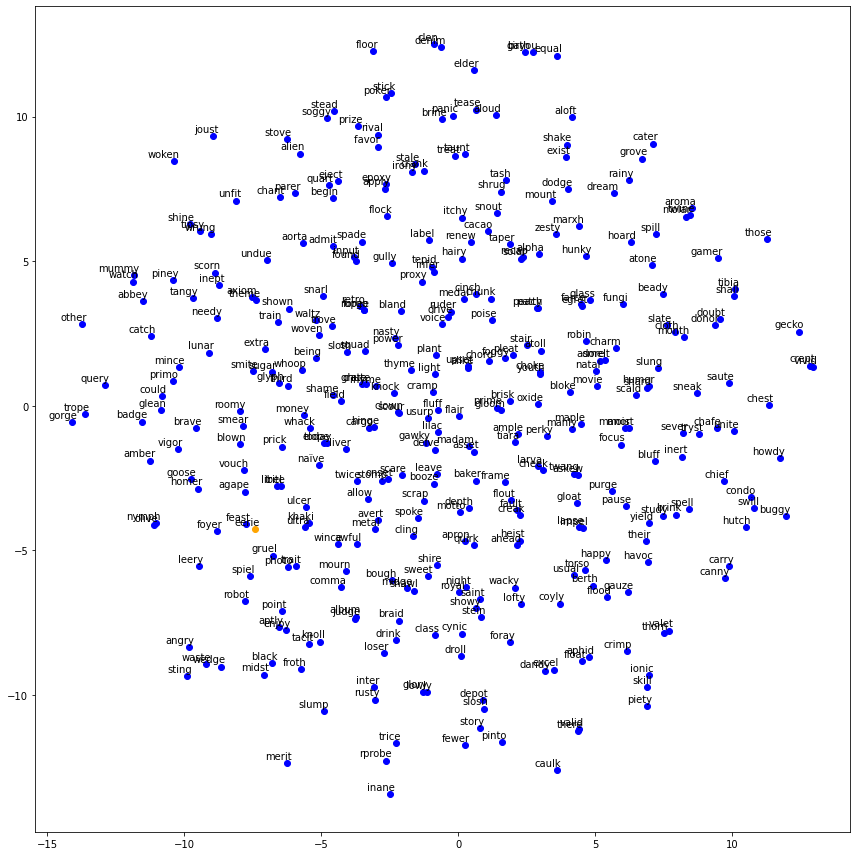

In [60]:
# Use the trained model to classify an unseen word 
unseen_words = np.append(words, 'eerie')
unseen_embed = create_word_embeddings(unseen_words, 30, True, True)

In [61]:
predicted_dist = model.predict(np.array([unseen_embed[1].wv['eerie']]))[0]
print(predicted_dist)
print(np.sum(predicted_dist * [1, 2, 3, 4, 5, 6, 7]))

1/1 [==============================] - 0s 52ms/step
[0.02477444 0.05045734 0.23006865 0.32761803 0.23433924 0.10273809
 0.03000424]
4.124521631747484


## Word Difficulty Classification

In [47]:
#Decide difficulty based off majority vote
main_try = np.argmax(prob_dist, axis = 1)
try_counts = np.unique(main_try, return_counts = True)

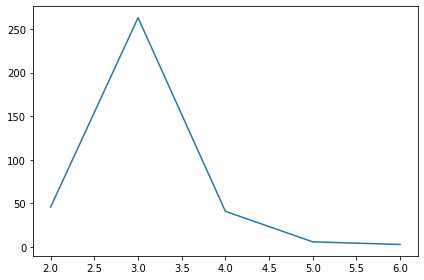

In [48]:
plt.plot(try_counts[0], try_counts[1])

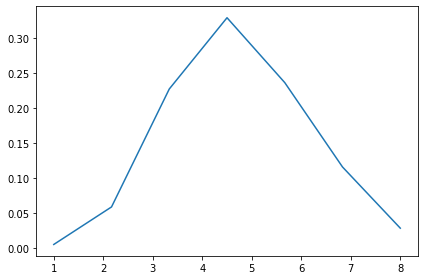

In [49]:
#Tries distribution
average_tries = np.average(prob_dist, axis = 0)
plt.plot(np.linspace(1,8,7), average_tries)

[]

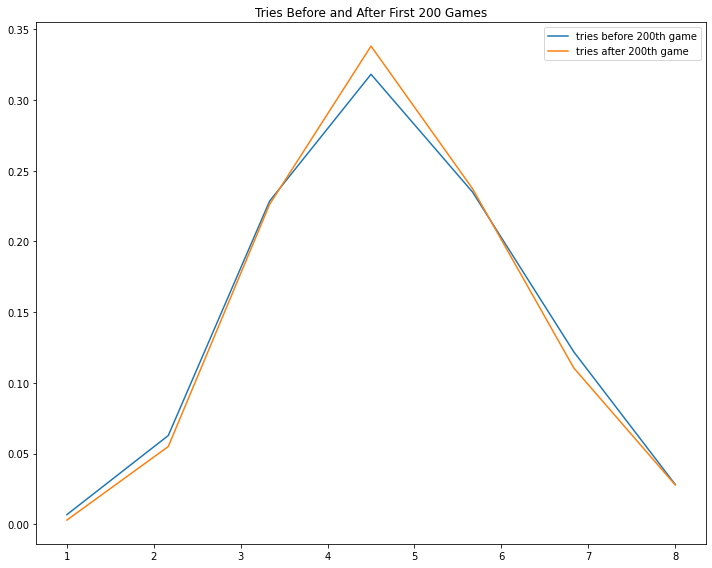

In [50]:
#Does the average number of tries chaneg as time goes on? Does the average number of tries change after the large curve A: No
plt.figure(figsize=(10, 8))
plt.title('Tries Before and After First 200 Games')
average_tries_earlier = np.average(prob_dist[200:], axis = 0)
average_tries_later = np.average(prob_dist[:200], axis = 0)
plt.plot(np.linspace(1,8,7), average_tries_earlier, label = 'tries before 200th game')
plt.plot(np.linspace(1,8,7), average_tries_later, label = 'tries after 200th game')
plt.legend()
plt.savefig('Tries Before and After First 200 Games.png')
plt.plot()

In [51]:
#The model we created for testing the difficulty label which should be applied to a new word is to
#plug in the proposed word into our neural network for it to receive a possible probability distribution across the number of tries by users
#then depending on the agreed upon labeling system we can assign a label:
# 2 proposed labeling systems:
# if the average of a score distribution is greater than 3.5 it is difficult otherwise its easy if(np.sum(predicted_dist * [1, 2, 3, 4, 5, 6, 7])) > 3.5: diff = hard else: easy
# We simply give the np.sum(predicted_dist * [1, 2, 3, 4, 5, 6, 7])) = predicted score as a difficulty score
# Since the proposed difficulty is based off of a neural network which is more or less a black box it is hard for us to comment on what specific attributes of the word 
# account for its difficulty but if our goal is to simply create a difficulty ranking system while not looking for literary insight 
#our proposed solution should be fine
#
#according to method 1 errie has a hard difficulty or by our second method a difficulty of 4 (more difficult than average but not hard)
#

In [52]:
scores_for_each_word = np.sum(np.linspace(1,8,7) * prob_dist, axis = 1)
scores_for_each_word = np.asarray([np.round(score) for score in scores_for_each_word])

In [53]:
hard_words = words[np.where(scores_for_each_word > 5)[0]]
easy_words = words[np.where(scores_for_each_word < 4)[0]]
print(hard_words)
print('\n')
print(easy_words)
print('\n')
hard_words = words[np.where(main_try > 4)[0]]
easy_words = words[np.where(main_try < 2.05)[0]]
print(hard_words)
print('\n')
print(easy_words)
print('\n')

['judge' 'mummy' 'ionic' 'dandy' 'parer' 'booze' 'gully' 'gauze' 'coyly'
 'cinch' 'trite' 'fluff' 'gawky' 'foyer' 'fewer' 'lowly' 'nymph' 'watch'
 'swill' 'proxy']


['train']


['judge' 'mummy' 'catch' 'parer' 'coyly' 'cinch' 'trite' 'foyer' 'watch']


['poise' 'third' 'slate' 'chord' 'braid' 'adore' 'tepid' 'clen' 'drive'
 'there' 'rainy' 'stale' 'dream' 'aloud' 'stein' 'sloth' 'grate' 'saint'
 'stick' 'chute' 'treat' 'alien' 'night' 'rusty' 'atone' 'peach' 'tiara'
 'shine' 'train' 'tash' 'heist' 'plant' 'stair' 'trope' 'chest' 'their'
 'tease' 'chant' 'thorn' 'moist' 'those' 'point' 'shire' 'solar' 'panic'
 'drink']




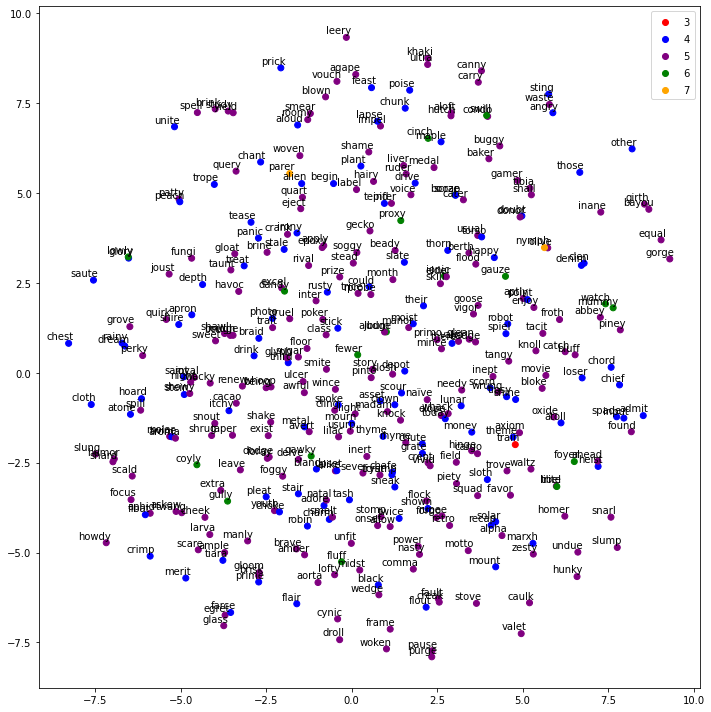

In [66]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 10))
colors = ListedColormap(['red', 'blue', 'purple', 'green','orange'])
for i, word in enumerate(words):
  x, y = embed_2d[i, :]
  plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

scatter = plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c = scores_for_each_word, cmap = colors)

plt.legend(*scatter.legend_elements())
plt.show()

In [55]:
easy_hard = np.asarray([1 if score > 4 else 0 for score in scores_for_each_word])

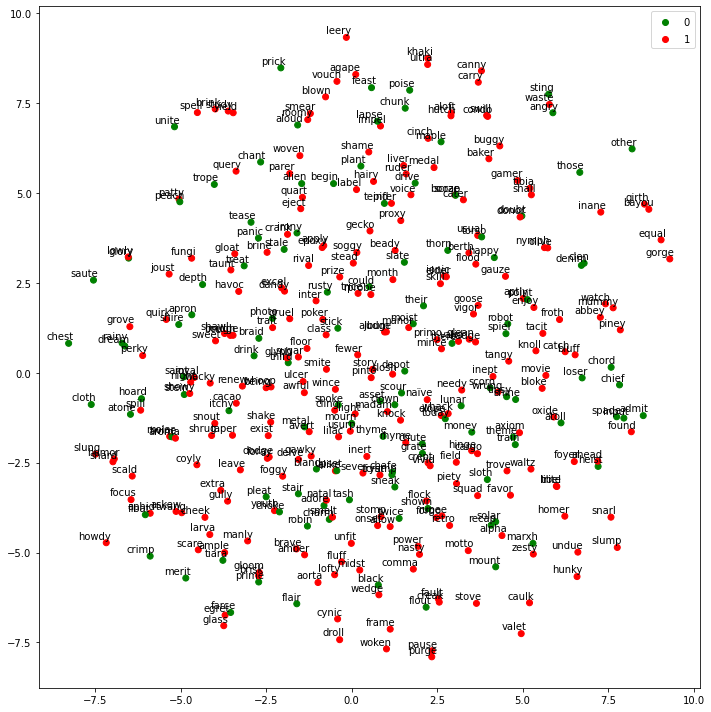

In [67]:
plt.figure(figsize=(10, 10))
colors = ListedColormap(['green','red'])
for i, word in enumerate(words):
  x, y = embed_2d[i, :]
  plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

scatter = plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c = easy_hard, cmap = colors)

plt.legend(*scatter.legend_elements())
plt.show()